In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

from networks.generator import ResNetGenerator

In [2]:
simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
mnist_trainset = datasets.MNIST(root='./datasets/mnist', train=True, download=True, transform=simple)

torch.Size([2, 1, 28, 28])


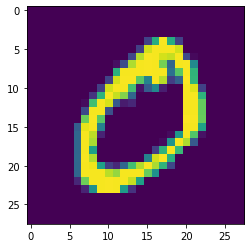

In [3]:
mnist_loader = DataLoader(mnist_trainset, batch_size=2)
for img, label in mnist_loader:
    print(img.shape)
    plt.imshow(img[1][0])
    plt.show()
    break

In [4]:
model = ResNetGenerator(conv_dim=5, c_dim=1, repeat_num=1, kernel_size=3, n_down=2)

In [5]:
model(img[0][0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 5 1 3 3, but got 2-dimensional input of size [28, 28] instead